Se analizaran los datos de Grupo Financiero Inbursa, desde el 7-02-2001 hasta 4-02-2021

In [1]:
import torch, pywt, csv, numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import reader1 as rd
import utilerias as utls
#import pyrenn as renn
from NARNN import NARNN 


/home/miguel/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2023-10-13 00:40:06.199937: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-13 00:40:06.617535: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-13 00:40:06.617636: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-13 00:40:06.619170: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS wh

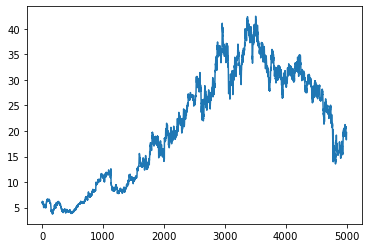

In [2]:

# Abrir el archivo CSV en modo lectura
#DATOS = 'C_Egipto_diario.csv'
DATOS = 'cierre.csv'
#Grupo Financiero Inbursa
cierre_inbursa = rd.leer_archivo('cierre.csv')
cierre = rd.leer_archivo(DATOS)
#se convierten todos los valores a flotantes
cierre = cierre.astype(float)
x = np.arange(1, (cierre.shape[0]+1))
EPOCAS = 50

# Crear un gráfico de línea con los valores de x, y
plt.plot(x, cierre)

# Mostrar el gráfico
plt.show()

#Eleccion de Mother Wavelet

Se elige las mother wavelets dependiendo de las caracteristicas de la serie de tiempo que se va a analizar. Para series que impliquen cambios no periodicos y repentinos es recomendable usar Haar ya que responde bien a estos cambios repentinos.

Se elige bior3.5 debido a las caracteristicas de las fluctuaciones entre periodos con altas cantidades de inversiones y periodos en los que no.

En general, el mother wavelet debe de ser una funcion de las caracteristicas de la serie original para que esta pueda ser reconstruida o analizada 

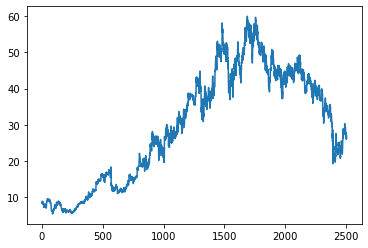

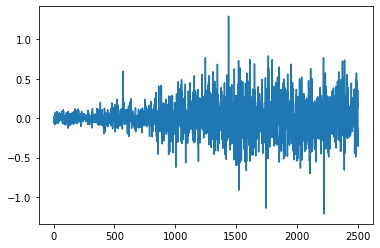

In [3]:
#Se descompone la lista de precios de cierre del intervalo mencionado anteriormente a partir de la dwt con la función bior3.5
(cA, cD) = pywt.dwt(cierre.tolist(), 'bior3.5')

# cA.size = 2505, cD.size = 2505
plt.plot(x[:len(cA)], cA[:len(cA)])
plt.show()

plt.plot(x[:len(cD)], cD[:len(cD)])
plt.show()

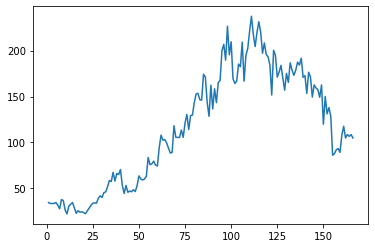

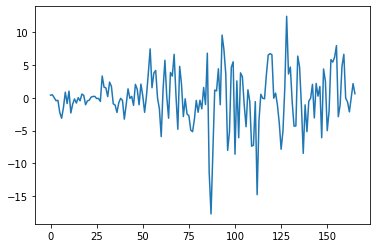

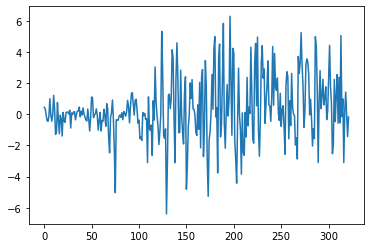

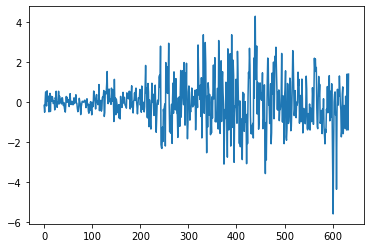

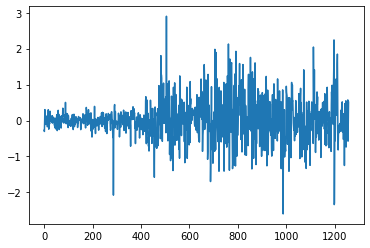

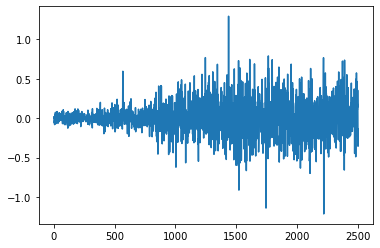

In [4]:
#Se realiza el proceso 5 veces
coeffs = pywt.wavedec(cierre, 'bior3.5', level=5)

cA = coeffs[0]
plt.plot(x[:len(cA)], cA)
plt.show()

cD_1 = coeffs[1]
cD_2 = coeffs[2]
cD_3 = coeffs[3]
cD_4 = coeffs[4]
cD_5 = coeffs[5]
plt.plot(range(len(cD_1)), cD_1)
plt.show()

plt.plot(range(len(cD_2)), cD_2)
plt.show()

plt.plot(range(len(cD_3)), cD_3)
plt.show()

plt.plot(range(len(cD_4)), cD_4)
plt.show()

plt.plot(range(len(cD_5)), cD_5)
plt.show()


In [5]:
A5=coeffs[0]#coeficientes de analisis
D1=coeffs[1]#coeficientes de detalle
D2=coeffs[2]
D3=coeffs[3]
D4=coeffs[4]
D5=coeffs[5]

#Se normalizan cada uno de los elementos de los vectores contenidos en las descomposicion de la serie de tiempo original
coeffs_n = [utls.normalizar(vect) for vect in coeffs]

#Estos 6 arreglos representan la descomposición de la señal original. Se tendrán que armar 6 redes que predigan cada una de estas
#componentes, Las entradas correspondientes a cada una son las 8 semanas anteriores para calcular la novena


entrenamiento,prueba,validacion = utls.generar_conjuntos(coeffs_n,False,5)
#la de abajo es una prueba
#entrenamiento,prueba,validacion = utls.generar_conjuntos([[1,2,3,4,5,6,7,8,9,10],[1,2,3,4,5,6,7,8,9,10]],False,1)

In [6]:
red_A1 = NARNN(input_dim=8, hidden_dim=0, output_dim=1, num_layers=0)
red_D1 = NARNN(input_dim=8, hidden_dim=0, output_dim=1, num_layers=0)
red_D2 = NARNN(input_dim=8, hidden_dim=0, output_dim=1, num_layers=0)
red_D3 = NARNN(input_dim=8, hidden_dim=0, output_dim=1, num_layers=0)
red_D4 = NARNN(input_dim=8, hidden_dim=0, output_dim=1, num_layers=0)
red_D5 = NARNN(input_dim=8, hidden_dim=0, output_dim=1, num_layers=0)


#entradas ya procesadas
entradas_8_1 = [[],[],[],[],[],[]]

# A cada uno de los conjuntos de entrenamiento se les da una forma de entrada en especifico,
# que es un arreglo de 8 y uno de un solo elemento para representar la salida
for e in range(6):
    entradas_8_1[e] = utls.corrimiento_t_1(entrenamiento[e],9)
    
#la forma de la entrada de la red neuronal
print(entradas_8_1[0])
print(len(entradas_8_1[0]))
#salida = red(entradas_8_1[0][:, :8])
#print(salida)


[tensor([[0.0574, 0.0526, 0.0532, 0.0526, 0.0574, 0.0446, 0.0259, 0.0728, 0.0675]]), tensor([[0.0526, 0.0532, 0.0526, 0.0574, 0.0446, 0.0259, 0.0728, 0.0675, 0.0194]]), tensor([[0.0532, 0.0526, 0.0574, 0.0446, 0.0259, 0.0728, 0.0675, 0.0194, 0.0000]]), tensor([[0.0526, 0.0574, 0.0446, 0.0259, 0.0728, 0.0675, 0.0194, 0.0000, 0.0397]]), tensor([[0.0574, 0.0446, 0.0259, 0.0728, 0.0675, 0.0194, 0.0000, 0.0397, 0.0491]]), tensor([[0.0446, 0.0259, 0.0728, 0.0675, 0.0194, 0.0000, 0.0397, 0.0491, 0.0573]]), tensor([[0.0259, 0.0728, 0.0675, 0.0194, 0.0000, 0.0397, 0.0491, 0.0573, 0.0311]]), tensor([[0.0728, 0.0675, 0.0194, 0.0000, 0.0397, 0.0491, 0.0573, 0.0311, 0.0034]]), tensor([[0.0675, 0.0194, 0.0000, 0.0397, 0.0491, 0.0573, 0.0311, 0.0034, 0.0163]]), tensor([[0.0194, 0.0000, 0.0397, 0.0491, 0.0573, 0.0311, 0.0034, 0.0163, 0.0088]]), tensor([[0.0000, 0.0397, 0.0491, 0.0573, 0.0311, 0.0034, 0.0163, 0.0088, 0.0105]]), tensor([[0.0397, 0.0491, 0.0573, 0.0311, 0.0034, 0.0163, 0.0088, 0.0105, 0.

In [7]:


#cada entrenamiento tarda aproximadamente 5 min con 1000 epocas
#params = red_A1.parameters()
#--utls.entrena(red_A1,0,entradas_8_1,50)
utls.entrena_LM(red_A1,0,entradas_8_1,EPOCAS)
#utls.entrena(entradas_8_1,red_D1,1)
#utls.entrena(entradas_8_1,red_D2,2)
#utls.entrena(entradas_8_1,red_D3,3)
#utls.entrena(entradas_8_1,red_D4,4)
#utls.entrena(entradas_8_1,red_D5,5)

paramtros antes: Parameter containing:
tensor([[ 0.2561, -0.1420,  0.2378, -0.2580,  0.2917,  0.0557,  0.0181, -0.3147],
        [ 0.0859, -0.0406, -0.3284, -0.2516,  0.1843,  0.2152, -0.2627,  0.1513],
        [-0.3466,  0.1331, -0.0436,  0.1659, -0.2509,  0.1245, -0.3072, -0.1035],
        [-0.2927,  0.3321,  0.0759, -0.0102, -0.0682,  0.3489, -0.0249,  0.1770],
        [ 0.0729,  0.2627,  0.3481,  0.1840,  0.1357,  0.0989,  0.2749,  0.2029],
        [-0.2909, -0.1913, -0.2591, -0.1328, -0.2331, -0.0158, -0.3066, -0.2853],
        [ 0.2278, -0.0773,  0.1772,  0.1653,  0.0759,  0.0863, -0.2192, -0.0856],
        [ 0.2943, -0.1845,  0.3449, -0.0675, -0.0856, -0.1041,  0.0022, -0.3131],
        [ 0.2649,  0.2885,  0.2712,  0.1353, -0.3262, -0.1718, -0.1700,  0.2448],
        [-0.2452, -0.1037, -0.2977, -0.3478, -0.1490, -0.3064, -0.2845,  0.0081]],
       requires_grad=True)
INICIO DE EPOCA...
>>Ventana Actual: 1
 >> Entrada: tensor([[0.0574, 0.0526, 0.0532, 0.0526, 0.0574, 0.0446, 0.02

----->SALIDA DE LA RED OBTENIDA: tensor([[0.2029]], grad_fn=<AddmmBackward0>)
----->SALIDA ESPERADA: tensor([0.0675])
>>Fin de paso
>>Se calcula perdida despues del paso...
----->SALIDA DE LA RED OBTENIDA: tensor([[0.1975]], grad_fn=<AddmmBackward0>)
----->SALIDA ESPERADA: tensor([0.0675])
Error Anterior: 0.01830882765352726
Error nuevo: 0.01687585562467575
Se registra la perdida: 1 tensor(0.0169, grad_fn=<MseLossBackward0>)
Finaliza exec...
paramtros red antes de salir del ejec Parameter containing:
tensor([[ 0.2561, -0.1419,  0.2378, -0.2580,  0.2917,  0.0557,  0.0182, -0.3147],
        [ 0.0859, -0.0405, -0.3284, -0.2515,  0.1844,  0.2153, -0.2627,  0.1513],
        [-0.3465,  0.1331, -0.0435,  0.1660, -0.2508,  0.1245, -0.3072, -0.1034],
        [-0.2927,  0.3321,  0.0759, -0.0102, -0.0682,  0.3489, -0.0249,  0.1770],
        [ 0.0728,  0.2627,  0.3481,  0.1839,  0.1356,  0.0989,  0.2749,  0.2028],
        [-0.2908, -0.1912, -0.2590, -0.1327, -0.2330, -0.0157, -0.3065, -0.2852],
  

In [ ]:
#print("paramtros despues: " + str([i for i in red_A1.parameters()][0]))
#print(red_A1(torch.Tensor([0.8709, 0.6840, 0.6600, 0.6713, 0.7581, 0.7445, 0.8692, 0.6714])))

paramtros despues: Parameter containing:
tensor([[ 0.3873,  0.3316,  0.2675,  0.3587,  0.3087, -0.1542,  0.2603, -0.1398],
        [ 0.3739, -0.1674,  0.0660, -0.0778, -0.0989,  0.3382, -0.0066, -0.0614],
        [-0.2607,  0.3110, -0.2148,  0.4084, -0.0835,  0.1657, -0.1994,  0.3180],
        [-0.0392,  0.4317, -0.0906,  0.4081, -0.0465, -0.1142, -0.0464,  0.1688],
        [-0.2735,  0.2958, -0.0657,  0.2140,  0.2566,  0.3013,  0.1904, -0.1714],
        [-0.1755,  0.0654, -0.1876,  0.0636,  0.0477,  0.1806,  0.2263,  0.3847],
        [-0.2603, -0.0568,  0.3141, -0.2015,  0.3003,  0.0269, -0.0503,  0.3226],
        [ 0.2029, -0.0020,  0.1875,  0.2331,  0.3015, -0.1255,  0.1256, -0.2820],
        [-0.2048,  0.3376, -0.0912,  0.2384, -0.0169,  0.4022,  0.0334, -0.2480],
        [ 0.1392,  0.3333,  0.1694, -0.1359, -0.1629, -0.0113, -0.1511,  0.3526]],
       requires_grad=True)
tensor([0.8322], grad_fn=<AddBackward0>)


In [ ]:
#entradas ya procesadas
#entradas_8_1 = [[],[],[],[],[],[]]

# A cada uno de los conjuntos de entrenamiento se les da una forma de entrada en especifico,
# que es un arreglo de 8 y uno de un solo elemento para representar la salida
# for e in range(6):
#     entradas_8_1[e] = utls.corrimiento_t_1(entrenamiento[e],9)

pruebas_ordenadas = []

# for e in range(6):
#     entradas_8_1[e] = utls.corrimiento_t_1(entrenamiento[e],9)

for c_pruebas in entrenamiento:#prueba
    #print("corrimiento: " + str(utls.corrimiento_t_1(c_pruebas,9)))
    pruebas_ordenadas.append(utls.corrimiento_t_1(c_pruebas,9))#prueba[0] es el conjunto de prueba para cada red
#pruebas = forma_entrada(prueba[0],9)#prueba[0] es el conjunto de prueba para A1
print(utls.genera_prediccion_1(pruebas_ordenadas[0],red_A1))
#print(len(utls.genera_prediccion(pruebas_ordenadas[0],red_A1).detach().numpy().tolist()[0]))
#print(entrenamiento[0])


/home/miguel/Documentos/Stock_Exchange_NN_PP/src/utilerias.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  serie = torch.tensor(c_pruebas[0][:, :8][0].clone().detach())


Salida predecida:tensor([[0.8522]], grad_fn=<AddmmBackward0>)
serie: tensor([0.0574, 0.0526, 0.0532, 0.0526, 0.0574, 0.0446, 0.0259, 0.0728, 0.8522],
       grad_fn=<CatBackward0>)
Salida predecida:tensor([[0.8523]], grad_fn=<AddmmBackward0>)
serie: tensor([0.0574, 0.0526, 0.0532, 0.0526, 0.0574, 0.0446, 0.0259, 0.0728, 0.8522,
        0.8523], grad_fn=<CatBackward0>)
Salida predecida:tensor([[0.8523]], grad_fn=<AddmmBackward0>)
serie: tensor([0.0574, 0.0526, 0.0532, 0.0526, 0.0574, 0.0446, 0.0259, 0.0728, 0.8522,
        0.8523, 0.8523], grad_fn=<CatBackward0>)
Salida predecida:tensor([[0.8526]], grad_fn=<AddmmBackward0>)
serie: tensor([0.0574, 0.0526, 0.0532, 0.0526, 0.0574, 0.0446, 0.0259, 0.0728, 0.8522,
        0.8523, 0.8523, 0.8526], grad_fn=<CatBackward0>)
Salida predecida:tensor([[0.8525]], grad_fn=<AddmmBackward0>)
serie: tensor([0.0574, 0.0526, 0.0532, 0.0526, 0.0574, 0.0446, 0.0259, 0.0728, 0.8522,
        0.8523, 0.8523, 0.8526, 0.8525], grad_fn=<CatBackward0>)
Salida pred

/home/miguel/Documentos/Stock_Exchange_NN_PP/src/utilerias.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  serie = torch.tensor(c_pruebas[0][:, :8][0].clone().detach())


Salida predecida:tensor([[0.8522]], grad_fn=<AddmmBackward0>)
serie: tensor([0.0574, 0.0526, 0.0532, 0.0526, 0.0574, 0.0446, 0.0259, 0.0728, 0.8522],
       grad_fn=<CatBackward0>)
Salida predecida:tensor([[0.8523]], grad_fn=<AddmmBackward0>)
serie: tensor([0.0574, 0.0526, 0.0532, 0.0526, 0.0574, 0.0446, 0.0259, 0.0728, 0.8522,
        0.8523], grad_fn=<CatBackward0>)
Salida predecida:tensor([[0.8523]], grad_fn=<AddmmBackward0>)
serie: tensor([0.0574, 0.0526, 0.0532, 0.0526, 0.0574, 0.0446, 0.0259, 0.0728, 0.8522,
        0.8523, 0.8523], grad_fn=<CatBackward0>)
Salida predecida:tensor([[0.8526]], grad_fn=<AddmmBackward0>)
serie: tensor([0.0574, 0.0526, 0.0532, 0.0526, 0.0574, 0.0446, 0.0259, 0.0728, 0.8522,
        0.8523, 0.8523, 0.8526], grad_fn=<CatBackward0>)
Salida predecida:tensor([[0.8525]], grad_fn=<AddmmBackward0>)
serie: tensor([0.0574, 0.0526, 0.0532, 0.0526, 0.0574, 0.0446, 0.0259, 0.0728, 0.8522,
        0.8523, 0.8523, 0.8526, 0.8525], grad_fn=<CatBackward0>)
Salida pred

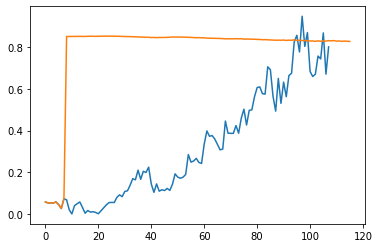

[0.81280927 0.86488167 0.80708521 0.79440233 0.75323313 0.60158617
 0.82804043 0.80158034 0.69185568 0.71781569 0.75158265 0.689009
 0.6259552  0.71098042 0.66563454 0.76420858 0.72824393 0.70097231
 0.72644053 0.76779128 0.75298823 0.78775683 0.6913776  0.69977333
 0.60954454 0.7166723  0.69280521 0.59122007 0.65289663 0.63678634
 0.62863523 0.5897861  0.65217408 0.45366899 0.5944051  0.50599046
 0.53791292 0.49539961 0.29700349 0.30497147 0.32464658 0.33062864
 0.31132227 0.39851368 0.44343923 0.38416685 0.40155024 0.392112
 0.40155024 0.38416685]


In [ ]:
plt.plot(range(108), entrenamiento[0][:-8])
plt.plot(range(116), utls.genera_prediccion_1(pruebas_ordenadas[0],red_A1).detach().numpy())
plt.show()

#plt.plot(range(108), entrenamiento[0][:-8])
#plt.plot(range(108), [utls.desnormalizar(vect) for vect in utls.genera_prediccion(pruebas_ordenadas[0],red_A1).detach().numpy().tolist()[0]])
# Mostrar el gráfico
#plt.show()
#investigar bien la dwt y predecir la red con los corrimientos de 1, usando los datos que predice o solo los datos que le doy
#Lo que hace es generar una prediccion cada noveno día, con los datos que ya se le dan del entrenamiento, es preciso ajustar los parametros hasta que ambas series
#sean iguales
print(prueba[0])

#Generamos el entrenamiento predictivo

In [ ]:
#print(entradas_8_1)
utls.entrena_LM_1(red_A1,0,entradas_8_1,EPOCAS)

tensor([[0.0574, 0.0526, 0.0532, 0.0526, 0.0574, 0.0446, 0.0259, 0.0728, 0.0675]])
INICIO DE EPOCA...
>>Ventana Actual: 1
serie: tensor([0.0574, 0.0526, 0.0532, 0.0526, 0.0574, 0.0446, 0.0259, 0.0728])
Entradaas: tensor([0.0574, 0.0526, 0.0532, 0.0526, 0.0574, 0.0446, 0.0259, 0.0728])
 >> Entrada: tensor([0.0574, 0.0526, 0.0532, 0.0526, 0.0574, 0.0446, 0.0259, 0.0728])
>>Se calcula perdida inicial...
----->SALIDA DE LA RED OBTENIDA: tensor([0.8522], grad_fn=<AddBackward0>)
----->SALIDA ESPERADA: tensor([0.0675])
epoca: 1
>>Inicio de paso (Los valores de la perdida aqui contenidos solo son usados para calculos)
----->SALIDA DE LA RED OBTENIDA: tensor([0.8522], grad_fn=<AddBackward0>)
----->SALIDA ESPERADA: tensor([0.0675])


/home/miguel/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


----->SALIDA DE LA RED OBTENIDA: tensor([0.8522], grad_fn=<AddBackward0>)
----->SALIDA ESPERADA: tensor([0.0675])
>>Fin de paso
>>Se calcula perdida despues del paso...
----->SALIDA DE LA RED OBTENIDA: tensor([0.7775], grad_fn=<AddBackward0>)
----->SALIDA ESPERADA: tensor([0.0675])
Error Anterior: 0.6157532930374146
Error nuevo: 0.5040167570114136
Se registra la perdida: 1 tensor(0.5040, grad_fn=<MseLossBackward0>)
Finaliza exec...
paramtros red antes de salir del ejec Parameter containing:
tensor([[ 0.3873,  0.3316,  0.2675,  0.3587,  0.3087, -0.1542,  0.2603, -0.1398],
        [ 0.3739, -0.1675,  0.0660, -0.0778, -0.0990,  0.3382, -0.0066, -0.0614],
        [-0.2607,  0.3110, -0.2148,  0.4084, -0.0835,  0.1657, -0.1994,  0.3180],
        [-0.0392,  0.4317, -0.0906,  0.4082, -0.0465, -0.1142, -0.0464,  0.1688],
        [-0.2735,  0.2958, -0.0657,  0.2140,  0.2566,  0.3013,  0.1904, -0.1714],
        [-0.1755,  0.0654, -0.1877,  0.0636,  0.0477,  0.1806,  0.2263,  0.3847],
        [-0.

KeyboardInterrupt: 

/home/miguel/Documentos/Stock_Exchange_NN_PP/src/utilerias.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  serie = torch.tensor(c_pruebas[0][:, :8][0].clone().detach())


Salida predecida:tensor([[0.7171]], grad_fn=<AddmmBackward0>)
serie: tensor([0.0574, 0.0526, 0.0532, 0.0526, 0.0574, 0.0446, 0.0259, 0.0728, 0.7171],
       grad_fn=<CatBackward0>)
Salida predecida:tensor([[0.7167]], grad_fn=<AddmmBackward0>)
serie: tensor([0.0574, 0.0526, 0.0532, 0.0526, 0.0574, 0.0446, 0.0259, 0.0728, 0.7171,
        0.7167], grad_fn=<CatBackward0>)
Salida predecida:tensor([[0.7170]], grad_fn=<AddmmBackward0>)
serie: tensor([0.0574, 0.0526, 0.0532, 0.0526, 0.0574, 0.0446, 0.0259, 0.0728, 0.7171,
        0.7167, 0.7170], grad_fn=<CatBackward0>)
Salida predecida:tensor([[0.7171]], grad_fn=<AddmmBackward0>)
serie: tensor([0.0574, 0.0526, 0.0532, 0.0526, 0.0574, 0.0446, 0.0259, 0.0728, 0.7171,
        0.7167, 0.7170, 0.7171], grad_fn=<CatBackward0>)
Salida predecida:tensor([[0.7171]], grad_fn=<AddmmBackward0>)
serie: tensor([0.0574, 0.0526, 0.0532, 0.0526, 0.0574, 0.0446, 0.0259, 0.0728, 0.7171,
        0.7167, 0.7170, 0.7171, 0.7171], grad_fn=<CatBackward0>)
Salida pred

/home/miguel/Documentos/Stock_Exchange_NN_PP/src/utilerias.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  serie = torch.tensor(c_pruebas[0][:, :8][0].clone().detach())


serie: tensor([0.0574, 0.0526, 0.0532, 0.0526, 0.0574, 0.0446, 0.0259, 0.0728, 0.7171,
        0.7167, 0.7170, 0.7171, 0.7171, 0.7164, 0.7166, 0.7170, 0.7170, 0.7165,
        0.7164, 0.7166, 0.7166, 0.7167, 0.7163, 0.7161, 0.7162, 0.7162, 0.7163,
        0.7163, 0.7164, 0.7165, 0.7168, 0.7171, 0.7171, 0.7173, 0.7173, 0.7177,
        0.7180, 0.7179, 0.7187, 0.7183, 0.7192, 0.7188, 0.7200, 0.7194, 0.7191,
        0.7192, 0.7191, 0.7191, 0.7180], grad_fn=<CatBackward0>)
Salida predecida:tensor([[0.7183]], grad_fn=<AddmmBackward0>)
serie: tensor([0.0574, 0.0526, 0.0532, 0.0526, 0.0574, 0.0446, 0.0259, 0.0728, 0.7171,
        0.7167, 0.7170, 0.7171, 0.7171, 0.7164, 0.7166, 0.7170, 0.7170, 0.7165,
        0.7164, 0.7166, 0.7166, 0.7167, 0.7163, 0.7161, 0.7162, 0.7162, 0.7163,
        0.7163, 0.7164, 0.7165, 0.7168, 0.7171, 0.7171, 0.7173, 0.7173, 0.7177,
        0.7180, 0.7179, 0.7187, 0.7183, 0.7192, 0.7188, 0.7200, 0.7194, 0.7191,
        0.7192, 0.7191, 0.7191, 0.7180, 0.7183], grad_fn=<C

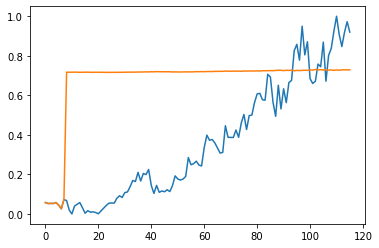

In [ ]:

pruebas_ordenadas_p = []

for c_pruebas in entrenamiento:#prueba
    pruebas_ordenadas_p.append(utls.corrimiento_t_1(c_pruebas,9))#prueba[0] es el conjunto de prueba para cada red
print(utls.genera_prediccion_1(pruebas_ordenadas_p[0],red_A1))

plt.plot(range(116), entrenamiento[0])
plt.plot(range(116), utls.genera_prediccion_1(pruebas_ordenadas_p[0],red_A1).detach().numpy())
plt.show()
